<a href="https://colab.research.google.com/github/Jeremy26/neural_optimization_course/blob/main/Model_Pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the Pruning Workshop!

In this workshop, we'll learn the concept of Pruning Neural Network models using Pytorch. We'll do the following tasks:
1. **Dataset** — Download and use FashionMNIST dataset
2. **Network** — Define a custom neural net and measure the metrics
3. **Training** — Train the model on the dataset, and record the accuracy metrics
4. **Pruning** — Apply different Pruning techniques on the model
5. **Analysis** — Visualize the results and find the best!

### Basic Imports

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from typing import Any, List
from sklearn.metrics import accuracy_score
import pandas as pd
from tqdm import tqdm

# DL library imports
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn, optim
import torch.nn.functional as F

In [2]:
!wget https://optimization-thinkautonomous.s3.eu-west-3.amazonaws.com/pruning.zip && unzip -q pruning.zip && rm pruning.zip

--2022-02-02 12:52:56--  https://optimization-thinkautonomous.s3.eu-west-3.amazonaws.com/pruning.zip
Resolving optimization-thinkautonomous.s3.eu-west-3.amazonaws.com (optimization-thinkautonomous.s3.eu-west-3.amazonaws.com)... 52.95.154.40
Connecting to optimization-thinkautonomous.s3.eu-west-3.amazonaws.com (optimization-thinkautonomous.s3.eu-west-3.amazonaws.com)|52.95.154.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78150 (76K) [application/zip]
Saving to: ‘pruning.zip’

pruning.zip         100%[===================>]  76.32K   286KB/s    in 0.3s    

2022-02-02 12:52:57 (286 KB/s) - ‘pruning.zip’ saved [78150/78150]



## 1 — **Dataset**: Download and use the Fashion MNIST Dataset


Here, we're going to use the FashionMNIST dataset for this case study.
- Fashion MNIST dataset is Zalando's collection of grayscale images of different apparels and their associated labels for Deep Learning research and development
- It consists of 60k train images and 10k test images, each of resolution 28 X 28 pixels
- The images contain integer values in range [0-255] and there are 10 labels. eg : 0 = T-shirt/top, 1 = Trouser, 2 = Pullover, 3 = Dress etc
- [Zalando FashionMNIST git repo](https://github.com/zalandoresearch/fashion-mnist)

In [3]:
datasetLabels = ['TShirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'AnkleBoot']

# necessary image transform i.e. convert to Tensor, normalize
trainTransform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)) ])
testTransform  = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)) ])

# Download the Train and Test set
trainSet = datasets.FashionMNIST('.', train=True, download=True, transform=trainTransform)
testSet = datasets.FashionMNIST('.', train=False, download=True, transform=testTransform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



### Define HyperParameters

In [4]:
NUM_WORKERS = 1 
TEST_BATCH_SIZE  = 64
TRAIN_BATCH_SIZE = 16
VALID_SIZE = 0.2 

### Train/Test Split

In [5]:
lenTrainSet = len(trainSet)
indexList = list(range(lenTrainSet))
np.random.shuffle(indexList)
splitIndex = int(lenTrainSet * VALID_SIZE)
trainIndices, validIndices = indexList[splitIndex:], indexList[:splitIndex]
trainSampler = SubsetRandomSampler(trainIndices)
validSampler = SubsetRandomSampler(validIndices)

### DataLoader

In [6]:
trainLoader = DataLoader(trainSet, batch_size=TRAIN_BATCH_SIZE, sampler=trainSampler, num_workers=NUM_WORKERS)
validLoader = DataLoader(trainSet, batch_size=TEST_BATCH_SIZE,  sampler=validSampler, num_workers=NUM_WORKERS)
testLoader  = DataLoader(testSet,  batch_size=TEST_BATCH_SIZE,  shuffle=True,num_workers=NUM_WORKERS)

### Visualization

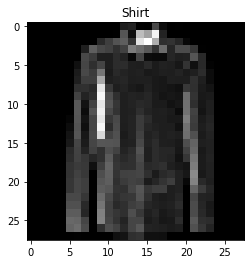

In [7]:
img, label = next(iter(trainLoader))
plt.imshow(img[0].numpy().squeeze(), cmap = 'Greys_r')
plt.title(f'{datasetLabels[label[0].item()]}')
plt.show()

## 2 — **Network**: Define a custom neural net and measure the metrics

- We'll use a simple feed forward model that takes in flattened image vector (28x28=784) and outputs probabilities for each of 10 classes.
- In Pytorch, we can create the Neural Network model by defining a custom class (inherits from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)).
- The `forward` function in the class defines the forward pass of the network.

In [8]:
class MLPClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128, bias=True)
        self.fc2 = nn.Linear(128, 64, bias=True)
        self.fc3 = nn.Linear(64, 32, bias=True)
        self.fc4 = nn.Linear(32, 10, bias=True)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

#### Print the Model Metrics

We'll use the functions used in the `metrics` notebook to print inference parameters of our custom model 

In [9]:
# Load the Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPClassifier().to(device)

In [10]:
from modelMetrics import computeInferenceTime, getModelFileSize, profile, getModelSize

def print_model_metrics(model, input):
  print("-------------------")
  print("Model Size: ", str(round(getModelSize(model),3)),"Mb")
  print("File Size: ", str(round(getModelFileSize(model),3)),"Mb")
  print("Inference Time: ",str(round(computeInferenceTime(model,randomInput, device),5)),"s")
  macs, params = profile(model, inputs=(randomInput,), verbose=False)
  flops = 2 * macs
  print("Mega FLOPS: ", str(flops * 1e-6))
  print("Mega MACs: ", str(macs * 1e-6))
  print("Mega Params: ", str(params * 1e-6))


randomInput = torch.rand(2, 28, 28).to(device)
print_model_metrics(model, randomInput)

-------------------
Model Size:  0.424 Mb
File Size:  0.447 Mb
Inference Time:  0.00037 s
Mega FLOPS:  0.443648
Mega MACs:  0.221824
Mega Params:  0.111146


#### Print the Model Sparsity

- Model sparsity refers to the ratio of parameters with zero weights to the total number of parameters. 
- Eg : If a linear layer with 100 neurons and 25 of the neurons have been pruned (effectively set to zero) then the sparsity of the layer is 25%.
- Sparsity can be calculated for each layers and for the entire model as well (referred to as Global sparsity)


In [11]:
def get_model_sparsity(model):
    totalElements = 0
    totalZeroElements = 0
    for name, module in model.named_children():
        numElementsInLayer = float(module.weight.nelement())
        numZeroElementsInLayer = float(torch.sum(module.weight == 0))
        print(f"{name},{numElementsInLayer}, {numZeroElementsInLayer}")
        layerWeightSparsity = 100.0 * (numZeroElementsInLayer/ numElementsInLayer)
        print(f"Sparsity in {name}.weight: {layerWeightSparsity}%.")
        
        totalElements += numElementsInLayer
        totalZeroElements += numZeroElementsInLayer
    
    if totalElements > 0 :
        globalWeightSparsity = 100.0 * (totalZeroElements / totalElements)
    else:
        globalWeightSparsity = 0.0
    return globalWeightSparsity
    

sparsity = get_model_sparsity(model)
print(f"Global Sparsity (weight): {sparsity}%")

fc1,100352.0, 0.0
Sparsity in fc1.weight: 0.0%.
fc2,8192.0, 0.0
Sparsity in fc2.weight: 0.0%.
fc3,2048.0, 0.0
Sparsity in fc3.weight: 0.0%.
fc4,320.0, 0.0
Sparsity in fc4.weight: 0.0%.
Global Sparsity (weight): 0.0%


## 3 - **Training**: Train the model on the dataset, and record the accuracy metrics

Before we train our model, we'll define some helper functions to calculate metric, plot training results etc

In [12]:
class meanClassificationAccuracyMetric:
    """
    Class to find the avg accuracy of softmax predictions to ground truth label
        CFG (Any): object containing num_classes 
        device (torch.device): compute device
    """    
    def __init__(self, CFG=None, device=None):
        self.batchAccuracies = []
        self.meanClassificationAccuracy = 0.0

    def update(self, y_preds: torch.Tensor, labels: torch.Tensor):
        """ Function finds the classification accuracy for the input batch

        Args:
            y_preds (torch.Tensor): model predictions
            labels (torch.Tensor): groundtruth labels        
        Returns
        """
        # predicted output class
        modelPredictions = np.argmax(torch.softmax(y_preds, axis=1).numpy(), axis=1)
        self.batchAccuracies.append(accuracy_score(labels.numpy(), modelPredictions))

    def compute(self):
        """ returns meanClassificationAccuracy """
        self.meanClassificationAccuracy = np.mean(self.batchAccuracies) * 100.0
        return self.meanClassificationAccuracy

    def reset(self):
        self.batchAccuracies = []
        self.meanClassificationAccuracy = 0.0

In [13]:
def plotTrainingResults(df:pd.DataFrame, modelName:str):
    """Function plots training, validation losses vs epoch
    Args:
        df (pd.DataFrame): Dataframe with the columns ['epoch', 'trainLoss', 'validationLoss']
        modelName (str): name of the model
    """   
    fig, ax1 = plt.subplots(figsize=(10,4))
    ax1_color = 'tab:red'
    ax1.set_ylabel('trainLoss', color=ax1_color)
    ax1.plot(df['epoch'].values, df['trainLoss'].values, color=ax1_color)
    ax1.tick_params(axis='y', labelcolor=ax1_color)

    ax2 = ax1.twinx()  
    ax2_color = 'tab:blue'    
    ax2.set_ylabel('validationLoss', color=ax2_color)
    ax2.plot(df['epoch'].values, df['validationLoss'].values, color=ax2_color)
    ax2.tick_params(axis='y', labelcolor=ax2_color)

    fig.tight_layout()
    plt.show()

In [14]:
def trainValidateModel(model, criterion, optimizer, dataloader_train, 
                       dataloader_valid, metricClass, metricName, device,
                       modelName):
    results = []    
    minValidationLoss = np.Inf
    lenTrainLoader = len(dataloader_train)

    # move model to target device
    model.to(device)
    
    for epoch in range(N_EPOCHS):
        print(f"Starting {epoch + 1} epoch ...")
        
        # Training
        model.train()
        trainLoss = 0.0
        for i, (inputs, labels) in tqdm(enumerate(dataloader_train), total=lenTrainLoader):
            inputs = inputs.to(device)
            labels = labels.to(device)  

            # Forward pass
            y_preds = model(inputs)
            loss = criterion(y_preds, labels)
            trainLoss += loss.item()
              
            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad() 
            
        # Validate
        model.eval()
        validationLoss = 0.0
        metricObject = metricClass(device=device)

        with torch.no_grad():
            for inputs, labels in dataloader_valid:
                inputs = inputs.to(device)
                labels = labels.to(device)                
                y_preds = model(inputs)
            
                # calculate loss
                loss = criterion(y_preds, labels)
                validationLoss += loss.item()

                # update batch metric information            
                metricObject.update(y_preds.cpu().detach(), labels.cpu().detach())

        # compute per batch losses
        trainLoss = trainLoss / len(dataloader_train)
        validationLoss = validationLoss / len(dataloader_valid)

        # compute metric
        validationMetric = metricObject.compute()

        print(f'Epoch: {epoch+1}, trainLoss:{trainLoss:6.5f}, validationLoss:{validationLoss:6.5f}, {metricName}:{validationMetric: 4.2f}%')
        
        # store results
        results.append({'epoch': epoch, 'trainLoss': trainLoss, 
                        'validationLoss': validationLoss, f'{metricName}': validationMetric})
        
        # if validation loss has decreased, save model and reset variable
        if validationLoss <= minValidationLoss:
            minValidationLoss = validationLoss
            torch.save(model.state_dict(), f'{modelName}.pt')

    # plot results
    results = pd.DataFrame(results)
    plotTrainingResults(results, f'{modelName}')

    return results

In [15]:
# Hyper parameters for training model
N_EPOCHS = 3
LR = 1e-2

# Define the Loss
criterion = nn.CrossEntropyLoss()

# Define the Optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

# train, validate standard model
modelResults = trainValidateModel(model, criterion, optimizer, trainLoader, validLoader, meanClassificationAccuracyMetric, 'accuracy', device, "Custom_MLP")

Starting 1 epoch ...


 18%|█▊        | 545/3000 [00:04<00:18, 134.03it/s]


KeyboardInterrupt: ignored

In [28]:
def evaluteOnTestData(model, pretrainedModelPath, device, 
                     dataloader_test, metricClass, metricName, modelName):
    testSetMetric = 0.0
    
    modelLoadStatus = False
    if pretrainedModelPath is not None:
        if os.path.isfile(pretrainedModelPath) == True:
            model.load_state_dict(torch.load(pretrainedModelPath, map_location=device))
            modelLoadStatus = True
    # no need to load model
    else:
        modelLoadStatus = True

    if modelLoadStatus == True:
        lenTestLoader = len(dataloader_test)
        model.to(device)
        # set to inference mode
        model.eval()
        metricObject = metricClass(device=device)

        with torch.no_grad():
            for inputs, labels in tqdm(dataloader_test, total=lenTestLoader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                y_preds = model(inputs)
            
                # update batch metric information            
                metricObject.update(y_preds.cpu().detach(), labels.cpu().detach())

        # compute metric of test set predictions
        testSetMetric = metricObject.compute()
        print(f'\n{modelName} has {testSetMetric} {metricName} on testData')

    else:
        print(f'Model cannot load state_dict from {pretrainedModelPath}')
    return testSetMetric

In [29]:
testSetMetric = evaluteOnTestData(model, "./Custom_MLP.pt", device, testLoader, 
                    meanClassificationAccuracyMetric, "Test_Accuracy", "Custom_MLP")

100%|██████████| 157/157 [00:01<00:00, 80.51it/s]


Custom_MLP has 82.00636942675159 Test_Accuracy on testData


## 4 - **Pruning**: Apply different Pruning techniques on the model

Now that we understand the pruning APIs in Pytorch, we'll use them to 
prune our custom MLP model. In the next section, we'll do the following:

- Apply the Unstructured pruning we learned above and also the Global version of it along with structured pruning on our trained model
- Observe the Accuracy of both the pruned model on Test set
- Apply different levels of Pruning percentages (*read sparsity levels*) and observe the different in performance metric

In [32]:
import torch.nn.utils.prune as prune

In [30]:
# Let's use different pruning percentages for each technique
prunePercentages = np.linspace(0.05, 0.90, 8).tolist()
print([round(x,3) for x in prunePercentages])

[0.05, 0.171, 0.293, 0.414, 0.536, 0.657, 0.779, 0.9]


### Layerwise Unstructured Pruning

In [33]:
def layer_unstructured_prune(model:nn.Module, prunePercentage:float):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=prunePercentage)
    return model

# placeholder to store results
l1_unstructured_accuracies = []

# iterate through each prune percentage
for perc in prunePercentages:
    # load the pretrained model
    model = MLPClassifier().to(device)
    model.load_state_dict(torch.load("./Custom_MLP.pt"))

    # prune the model
    unStructuredPruneModel = layer_unstructured_prune(model, perc)

    # evaluate the pruned model on test data
    l1_unstructured_accuracies.append(evaluteOnTestData(unStructuredPruneModel, None, \
          device, testLoader, meanClassificationAccuracyMetric, "Test accuracy", "Unstructured Prune"))    

100%|██████████| 157/157 [00:02<00:00, 78.07it/s]



Unstructured Prune has 81.99641719745223 Test accuracy on testData


100%|██████████| 157/157 [00:01<00:00, 80.52it/s]



Unstructured Prune has 81.91679936305732 Test accuracy on testData


100%|██████████| 157/157 [00:01<00:00, 82.67it/s]



Unstructured Prune has 73.23845541401273 Test accuracy on testData


100%|██████████| 157/157 [00:01<00:00, 82.54it/s]



Unstructured Prune has 65.48566878980891 Test accuracy on testData


100%|██████████| 157/157 [00:01<00:00, 83.04it/s]



Unstructured Prune has 47.88017515923567 Test accuracy on testData


100%|██████████| 157/157 [00:01<00:00, 80.86it/s]



Unstructured Prune has 25.35828025477707 Test accuracy on testData


100%|██████████| 157/157 [00:01<00:00, 80.52it/s]



Unstructured Prune has 18.093152866242036 Test accuracy on testData


100%|██████████| 157/157 [00:01<00:00, 82.78it/s]


Unstructured Prune has 15.605095541401273 Test accuracy on testData


### Layerwise structured pruning

In [34]:
def layer_structured_prune(model:nn.Module, prunePercentage:float):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            prune.ln_structured(module, name='weight', amount=prunePercentage, n=1, dim=0)
    return model


# placeholder to store results
l1_structured_accuracies = []

# iterate through each prune percentage
for perc in prunePercentages:
    # load the pretrained model
    model = MLPClassifier().to(device)
    model.load_state_dict(torch.load("./Custom_MLP.pt"))

    # prune the model
    structuredPruneModel = layer_structured_prune(model, perc)

    # evaluate the pruned model on test data
    l1_structured_accuracies.append(evaluteOnTestData(structuredPruneModel, None, \
          device, testLoader, meanClassificationAccuracyMetric, "Test accuracy", "structured Prune"))

100%|██████████| 157/157 [00:01<00:00, 82.43it/s]



structured Prune has 82.03622611464968 Test accuracy on testData


100%|██████████| 157/157 [00:01<00:00, 81.91it/s]



structured Prune has 75.109474522293 Test accuracy on testData


100%|██████████| 157/157 [00:02<00:00, 58.41it/s]



structured Prune has 65.44585987261146 Test accuracy on testData


100%|██████████| 157/157 [00:02<00:00, 68.64it/s]



structured Prune has 52.22929936305732 Test accuracy on testData


100%|██████████| 157/157 [00:01<00:00, 82.22it/s]



structured Prune has 40.72452229299363 Test accuracy on testData


100%|██████████| 157/157 [00:01<00:00, 82.50it/s]



structured Prune has 25.199044585987263 Test accuracy on testData


100%|██████████| 157/157 [00:01<00:00, 84.05it/s]



structured Prune has 9.96218152866242 Test accuracy on testData


100%|██████████| 157/157 [00:02<00:00, 78.39it/s]


structured Prune has 9.952229299363058 Test accuracy on testData


### Global Unstructured Pruning

In [35]:
def global_unstructured_prune(model:nn.Module, prunePercentage:float):
    parameters_to_prune = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, 'weight'))
    prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=prunePercentage)
    return model


# placeholder to store results
global_prune_accuracies = []

# iterate through each prune percentage
for perc in prunePercentages:
    # load the pretrained model
    model = MLPClassifier().to(device)
    model.load_state_dict(torch.load("./Custom_MLP.pt"))

    # prune the model
    globalPruneModel = global_unstructured_prune(model, perc)

    # evaluate the pruned model on test data
    global_prune_accuracies.append(evaluteOnTestData(globalPruneModel, None, \
          device, testLoader, meanClassificationAccuracyMetric, "Test accuracy", "structured Prune"))    

100%|██████████| 157/157 [00:01<00:00, 80.36it/s]



structured Prune has 82.09593949044586 Test accuracy on testData


100%|██████████| 157/157 [00:01<00:00, 79.40it/s]



structured Prune has 81.90684713375796 Test accuracy on testData


100%|██████████| 157/157 [00:02<00:00, 78.28it/s]



structured Prune has 81.82722929936305 Test accuracy on testData


100%|██████████| 157/157 [00:01<00:00, 78.91it/s]



structured Prune has 73.09912420382165 Test accuracy on testData


100%|██████████| 157/157 [00:02<00:00, 76.57it/s]



structured Prune has 66.49084394904459 Test accuracy on testData


100%|██████████| 157/157 [00:01<00:00, 80.39it/s]



structured Prune has 40.167197452229296 Test accuracy on testData


100%|██████████| 157/157 [00:01<00:00, 80.79it/s]



structured Prune has 14.599920382165605 Test accuracy on testData


100%|██████████| 157/157 [00:01<00:00, 79.53it/s]


structured Prune has 9.96218152866242 Test accuracy on testData


## 5 - **Analysis**: Visualize the results and find the best!


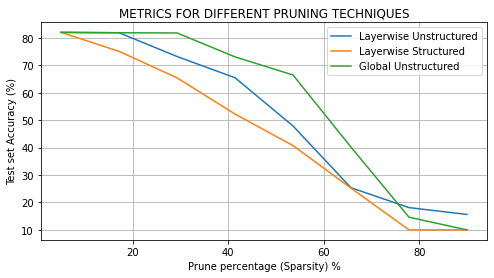

In [36]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(np.array(prunePercentages) * 100.0, np.array(l1_unstructured_accuracies), label='Layerwise Unstructured')
ax.plot(np.array(prunePercentages) * 100.0, np.array(l1_structured_accuracies), label='Layerwise Structured')
ax.plot(np.array(prunePercentages) * 100.0, np.array(global_prune_accuracies), label='Global Unstructured')
ax.set(xlabel ='Prune percentage (Sparsity) %', ylabel = 'Test set Accuracy (%)', \
       title = 'METRICS FOR DIFFERENT PRUNING TECHNIQUES')
ax.legend()
ax.grid(True)
plt.show()

### Observations

 - We can observe that even at ~55% Sparsity, layer wise unstructured pruning techniques maintain roughly 80% test accuracy.
 - Beyond a threshold (60% in our case), test accuracy drops significantly for all 3 techniques indicating the model is not able to capture enough information with the remaining weights
 - At least in our case, structured pruning is worse than unstructured pruning. 

**Now, let's plot all 4 layers of our custom model and see how different techiques have pruned weights**

In [39]:
def plot_fc_weight(weight, ax=None, cmap='viridis'):
  nrows, ncols = weight.shape
  x = np.arange(0,ncols)
  y = np.arange(0,nrows)
  X, Y = np.meshgrid(x,y)
  z_np = weight.detach().cpu().numpy()
  ln = ax.pcolor(X, Y, z_np, cmap=cmap)
  ax.axis('off')
  return ln

In [40]:
def plot_custom_model(model, title=''):
  fig, axes = plt.subplots(1,4,figsize=(16, 4), gridspec_kw={'width_ratios': [7,5,3,1]})
  plot_fc_weight(model.fc1.weight, axes[0])
  plot_fc_weight(model.fc2.weight, axes[1])
  plot_fc_weight(model.fc3.weight, axes[2])
  plot_fc_weight(model.fc4.weight, axes[3])
  
  axes[0].set_title('FC Layer1')
  axes[1].set_title('FC Layer2')
  axes[2].set_title('FC Layer3')
  axes[3].set_title('FC Layer4')
  
  if title is not '':
    plt.suptitle(title)

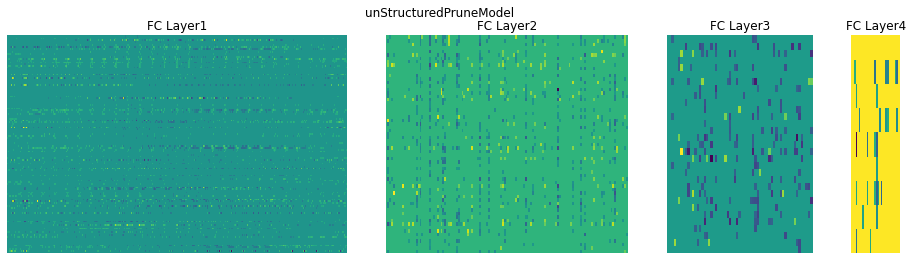

In [41]:
plot_custom_model(unStructuredPruneModel, title='unStructuredPruneModel')

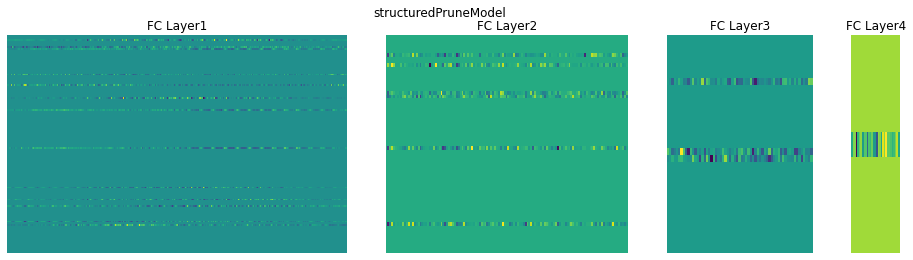

In [42]:
plot_custom_model(structuredPruneModel, title='structuredPruneModel')

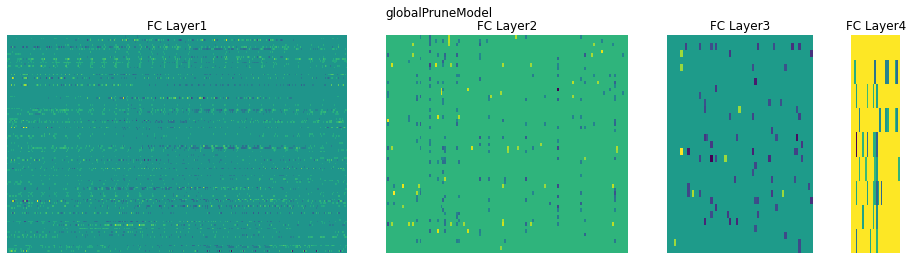

In [43]:
plot_custom_model(globalPruneModel, 'globalPruneModel')

### Notes —

Now that we pruned majority of our model, what performance improvement can we expect?

- For now, ***Pytorch pruning doesn't improve the runtime performance of the model. This is because, even though large percentage of weights can be set to zero, the forward pass still uses operations on the entire dense tensors of the model***
- ***Sparse tensor operations functionality is still very limited in Pytorch, but it has plans to incorporate optimizations to see effects of Pruning in production systems***
- To truly see the effect of the different pruning methods, we need to use a separate library that can optimize the model for pruned weights and apply it to production or recreate the pruned model structure from scratch